# Introduction

Since Jan. 1, 2015, [The Washington Post](https://www.washingtonpost.com/) has been compiling a database of every fatal shooting in the US by a police officer in the line of duty. 

<center><img src=https://i.imgur.com/sX3K62b.png></center>

While there are many challenges regarding data collection and reporting, The Washington Post has been tracking more than a dozen details about each killing. This includes the race, age and gender of the deceased, whether the person was armed, and whether the victim was experiencing a mental-health crisis. The Washington Post has gathered this supplemental information from law enforcement websites, local new reports, social media, and by monitoring independent databases such as "Killed by police" and "Fatal Encounters". The Post has also conducted additional reporting in many cases.

There are 4 additional datasets: US census data on poverty rate, high school graduation rate, median household income, and racial demographics. [Source of census data](https://factfinder.census.gov/faces/nav/jsf/pages/community_facts.xhtml).

### Upgrade Plotly

Run the cell below if you are working with Google Colab

In [57]:
%pip install --upgrade plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Statements

In [58]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import datetime as dt

# This might be helpful:
from collections import Counter
from functools import reduce
from plotly.subplots import make_subplots

## Notebook Presentation

In [59]:
pd.options.display.float_format = '{:,.2f}'.format

## Load the Data

In [60]:
df_hh_income = pd.read_csv('Median_Household_Income_2015.csv', encoding="windows-1252")
df_pct_poverty = pd.read_csv('Pct_People_Below_Poverty_Level.csv', encoding="windows-1252")
df_pct_completed_hs = pd.read_csv('Pct_Over_25_Completed_High_School.csv', encoding="windows-1252")
df_share_race_city = pd.read_csv('Share_of_Race_By_City.csv', encoding="windows-1252")
df_fatalities = pd.read_csv('Deaths_by_Police_US.csv', encoding="windows-1252")

# Preliminary Data Exploration

* What is the shape of the DataFrames? 
* How many rows and columns do they have?
* What are the column names?
* Are there any NaN values or duplicates?

In [61]:
[df_hh_income.info(), df_pct_completed_hs.info(), df_pct_poverty.info(), df_share_race_city.info(), df_fatalities.info()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29322 entries, 0 to 29321
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Geographic Area  29322 non-null  object
 1   City             29322 non-null  object
 2   Median Income    29271 non-null  object
dtypes: object(3)
memory usage: 687.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29329 entries, 0 to 29328
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Geographic Area       29329 non-null  object
 1   City                  29329 non-null  object
 2   percent_completed_hs  29329 non-null  object
dtypes: object(3)
memory usage: 687.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29329 entries, 0 to 29328
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Geographic Area  29329

[None, None, None, None, None]

## Data Cleaning - Check for Missing Values and Duplicates

Consider how to deal with the NaN values. Perhaps substituting 0 is appropriate. 

In [62]:
df_pct_poverty['poverty_rate'].replace("-","0", inplace=True,)
df_pct_poverty['poverty_rate'] = df_pct_poverty['poverty_rate'].astype(float)

In [63]:
df_pct_completed_hs = df_pct_completed_hs.drop(df_pct_completed_hs[df_pct_completed_hs['percent_completed_hs'] == '-'].index)
df_pct_completed_hs['percent_completed_hs'] = df_pct_completed_hs['percent_completed_hs'].astype(float)

In [64]:
df_share_race_city = df_share_race_city.drop(df_share_race_city[df_share_race_city['share_white'] == '(X)'].index)

df_share_race_city['share_white'] = df_share_race_city['share_white'].astype(float)
df_share_race_city['share_black'] = df_share_race_city['share_black'].astype(float)
df_share_race_city['share_native_american'] = df_share_race_city['share_native_american'].astype(float)
df_share_race_city['share_asian'] = df_share_race_city['share_asian'].astype(float)
df_share_race_city['share_hispanic'] = df_share_race_city['share_hispanic'].astype(float)

In [65]:

df_hh_income = df_hh_income.drop(df_hh_income[df_hh_income['Median Income'] == '-'].index)
df_hh_income = df_hh_income.drop(df_hh_income[df_hh_income['Median Income'] == '(X)'].index)
df_hh_income.loc[df_hh_income['Median Income'] == '2,500-', 'Median Income'] = "2000"
df_hh_income.loc[df_hh_income['Median Income'] == '250,000+', 'Median Income'] = "280000"
df_hh_income['Median Income'] = df_hh_income['Median Income'].astype(float)

In [66]:
df_fatalities.dropna(inplace=True)
df_fatalities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2254 entries, 0 to 2534
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2254 non-null   int64  
 1   name                     2254 non-null   object 
 2   date                     2254 non-null   object 
 3   manner_of_death          2254 non-null   object 
 4   armed                    2254 non-null   object 
 5   age                      2254 non-null   float64
 6   gender                   2254 non-null   object 
 7   race                     2254 non-null   object 
 8   city                     2254 non-null   object 
 9   state                    2254 non-null   object 
 10  signs_of_mental_illness  2254 non-null   bool   
 11  threat_level             2254 non-null   object 
 12  flee                     2254 non-null   object 
 13  body_camera              2254 non-null   bool   
dtypes: bool(2), float64(1), 

## Merging data from csv other than fatalitites

In [67]:
df_share_race_city.rename(columns={'Geographic area': 'Geographic Area'}, inplace= True)

In [68]:
dfs = [df_share_race_city, df_hh_income, df_pct_completed_hs, df_pct_poverty]

df_demographics = reduce(lambda  left,right: pd.merge(left,right,on=['Geographic Area', 'City'], how='outer'), dfs)
# df_demographics[df_demographics["share_native_american"].isna()]

In [69]:
print(f"Null Values Exist:{df_demographics.isna().values.any()}")
print(df_demographics["share_native_american"].isna().values.sum())
df_share_race_city["share_native_american"].isna().values.sum()

Null Values Exist:True
228


0

In [70]:
df_hh_income.duplicated().values.any()
df_demographics.dropna(inplace=True)

# Chart the Poverty Rate in each US State

Create a bar chart that ranks the poverty rate from highest to lowest by US state. Which state has the highest poverty rate? Which state has the lowest poverty rate?  Bar Plot

In [71]:
poverty_statewise = df_pct_poverty.groupby('Geographic Area', as_index=False).agg({'poverty_rate':['mean']})
poverty_statewise.columns= ['State','Average Poverty %']
poverty_statewise.sort_values(by='Average Poverty %', inplace=True)
poverty_statewise.tail(10)

,State,Average Poverty %
36,OK,20.55
1,AL,20.61
49,WV,21.08
40,SC,22.11
18,LA,22.29
32,NM,22.51
2,AR,22.96
10,GA,23.66
3,AZ,25.27
25,MS,26.88


In [72]:
fig = px.bar(poverty_statewise, x='State', y='Average Poverty %')
fig.show()

# Chart the High School Graduation Rate by US State

Show the High School Graduation Rate in ascending order of US States. Which state has the lowest high school graduation rate? Which state has the highest?

In [73]:
hsgrad = df_pct_completed_hs.groupby('Geographic Area', as_index=False).agg({'percent_completed_hs': 'mean'})
hsgrad.sort_values(by='percent_completed_hs', inplace=True)

In [74]:
fig = px.bar(hsgrad, x='Geographic Area', y='percent_completed_hs')
fig.show()

# Visualise the Relationship between Poverty Rates and High School Graduation Rates

#### Create a line chart with two y-axes to show if the rations of poverty and high school graduation move together.  

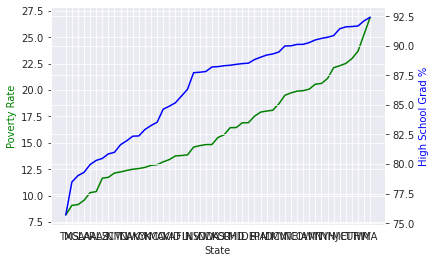

In [75]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(poverty_statewise['State'], poverty_statewise['Average Poverty %'], '-', color='g')
ax2.plot(hsgrad['Geographic Area'], hsgrad['percent_completed_hs'],'-', color='b')

ax1.set_xlabel('State')
ax1.set_ylabel('Poverty Rate', color='g')
ax2.set_ylabel('High School Grad %', color='b')

plt.show()

In [76]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
	go.Scatter(x=poverty_statewise['State'], y=poverty_statewise['Average Poverty %'], name="Poverty Rate"),
	secondary_y=False)

# Use add_trace function and specify secondary_y axes = True.
fig.add_trace(
	go.Scatter(x=hsgrad['Geographic Area'], y=hsgrad['percent_completed_hs'], 
            name="High School Graduation", mode='markers'),
	secondary_y=True,)

# Adding title text to the figure
fig.update_layout(
	title_text="Poverty rate vs High School Graduation"
)

# Naming axis
fig.update_xaxes(title_text="State")
fig.update_yaxes(title_text="<b>Poverty Rate</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>High School Graduation</b>", secondary_y=True)



#### Now use a Seaborn .jointplot() with a Kernel Density Estimate (KDE) and/or scatter plot to visualise the same relationship

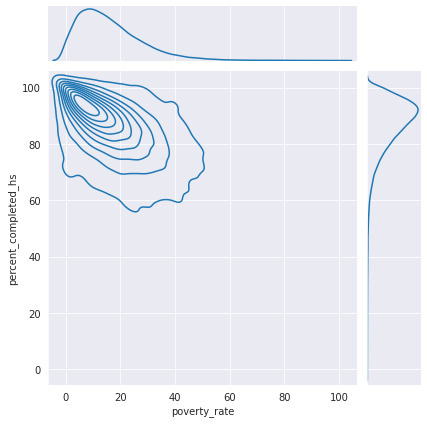

In [77]:
fig = sns.jointplot(data=df_demographics, x='poverty_rate', y='percent_completed_hs', kind='kde')

#### Seaborn's `.lmplot()` or `.regplot()` to show a linear regression between the poverty ratio and the high school graduation ratio. 

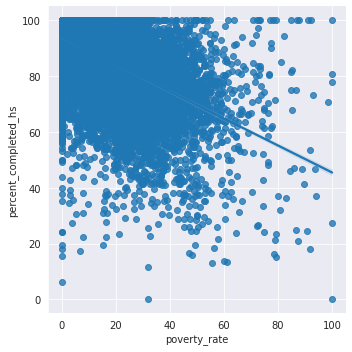

In [78]:
fig=sns.lmplot(data=df_demographics, x='poverty_rate', y='percent_completed_hs' )

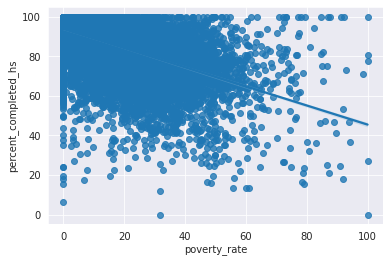

In [79]:
fig=sns.regplot(data=df_demographics, x='poverty_rate', y='percent_completed_hs' )

# Create a Bar Chart with Subsections Showing the Racial Makeup of Each US State

Visualise the share of the white, black, hispanic, asian and native american population in each US State using a bar chart with sub sections. 

In [100]:
race_statewise = df_share_race_city.groupby('Geographic Area', as_index=False).agg({'share_white':'mean', 'share_black': 'mean', 'share_native_american':'mean','share_asian': 'mean', 'share_hispanic': 'mean'})
race_statewise.columns = ['State', 'Whites', 'Blacks', 'Natives','Asians','Hispanics']


In [81]:
fig=px.bar(race_statewise, x='State', y=['Whites','Blacks','Natives','Asians','Hispanics'], barmode='stack')
fig.update_layout(yaxis_title= '% Population', title='Race percent of the states')
fig.show()

Something is definitely wrong with the data collected. Many cities have greater than 100% populatin values.

# Create Donut Chart by of People Killed by Race

Hint: Use `.value_counts()`

In [82]:
fig = px.pie(df_fatalities, names='race', title="Fatalities by Race", hole=0.5)
fig.update_traces(textinfo='value')
fig.show()

# Create a Chart Comparing the Total Number of Deaths of Men and Women

Use `df_fatalities` to illustrate how many more men are killed compared to women. 

In [83]:
fig=px.pie(df_fatalities, names='gender', title='Fatalities - Genderwise')
fig.update_traces(textinfo='value')
fig.show()

# Create a Box Plot Showing the Age and Manner of Death

Break out the data by gender using `df_fatalities`. Is there a difference between men and women in the manner of death? 

In [84]:
fig = px.box(df_fatalities, x='manner_of_death', y='age', title='Manner of death vs Age' )
fig.show()

In [85]:
fig = px.box(df_fatalities, x='gender', y='age', title='Gender vs Age' )
fig.show()

In [86]:
fig=px.bar(df_fatalities, x='manner_of_death', color = 'gender', title='Manner of death - Genderwise')
fig.show()

# Were People Armed? 

In what percentage of police killings were people armed? Create chart that show what kind of weapon (if any) the deceased was carrying. How many of the people killed by police were armed with guns versus unarmed? 

In [87]:
print(f"Percent of unarmed people killings:{len(df_fatalities[df_fatalities['armed'] == 'unarmed'])*100 / len(df_fatalities)} %")

Percent of unarmed people killings:7.320319432120674 %


In [88]:
fig = px.bar(df_fatalities, x='armed', title='Types of Weapons' )
fig.update_traces(marker_color = 'red')
fig.show()

In [89]:
gun_unarmed = df_fatalities[(df_fatalities['armed'] == 'gun') | (df_fatalities['armed'] == 'unarmed')]
fig=px.pie(gun_unarmed, names='armed', title="Armed with guns vs Unarmed", )
fig.update_traces(textinfo='value')
fig.show()

# How Old Were the People Killed?

Work out what percentage of people killed were under 25 years old.  

In [90]:
print(f"Percent of people younger than 25: {round((len(df_fatalities[df_fatalities['age'] < 26])*100 / len(df_fatalities)),2)}%")

Percent of people younger than 25: 22.94%


Create a histogram and KDE plot that shows the distribution of ages of the people killed by police. 

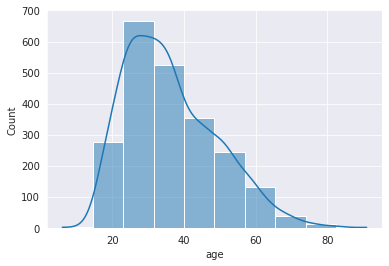

In [91]:
fig = sns.histplot(df_fatalities, x='age', bins = 10, kde=True)


Create a seperate KDE plot for each race. Is there a difference between the distributions? 

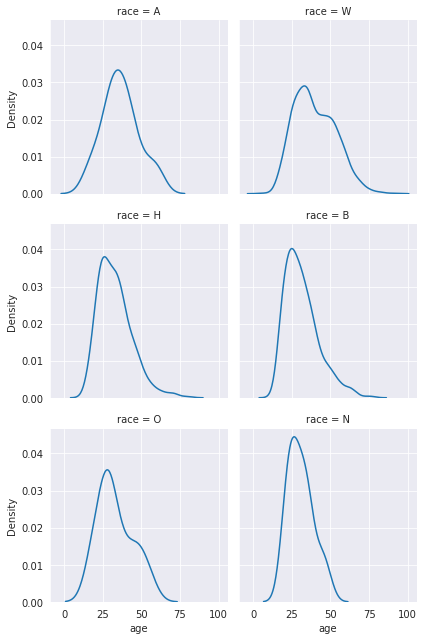

In [92]:
fig = sns.FacetGrid(data=df_fatalities, col='race', col_wrap=2)
fig.map(sns.kdeplot,'age')

The distribution of whites seems a bit closer to the original distribution. Most of the other distributions seem to be a bit peaking at around 30s but distribution at other ages seems lesser relative to original. 

# Race of People Killed

Create a chart that shows the total number of people killed by race. 

Text(0, 0.5, '# killed')

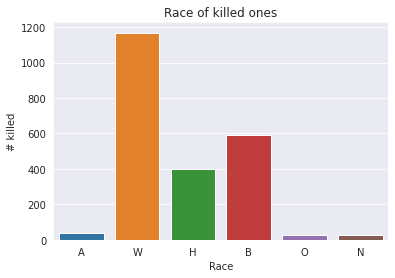

In [93]:
sns.set_style('darkgrid')
sns.countplot(data=df_fatalities, x='race')
plt.title('Race of killed ones')
plt.xlabel('Race')
plt.ylabel('# killed')

Looks like Asians and Natives are peaceful / don't get into trouble with Police. 

# Mental Illness and Police Killings

What percentage of people killed by police have been diagnosed with a mental illness?

In [94]:
fig=px.pie(df_fatalities, names='signs_of_mental_illness', hole=0.6, title='Signs of Mental illness')
fig.show()

25% of the ones killed by the Police are categorized as Mentally ill. Should probably look into how they classify them. 
Either they have a lot of violent people who are mentally ill or they are just categorized so for the sake of Police convenience. 

# In Which Cities Do the Most Police Killings Take Place?

Create a chart ranking the top 10 cities with the most police killings. Which cities are the most dangerous?  

In [95]:
city_dangerous = df_fatalities.groupby(['city','state'],as_index=False).size()
city_dangerous.sort_values('size', ascending= False, inplace=True)
city_dangerous.columns = ['City', 'Geographic Area', 'Fatalities']
print("Top 10 Dangerous cities are: ",
      city_dangerous.head(10))

Top 10 Dangerous cities are:                City Geographic Area  Fatalities
722    Los Angeles              CA          35
972        Phoenix              AZ          28
566        Houston              TX          23
232        Chicago              IL          22
681      Las Vegas              NV          17
67          Austin              TX          16
1087   San Antonio              TX          15
278       Columbus              OH          14
585   Indianapolis              IN          14
1186     St. Louis              MO          14


In [96]:
top_10_cities = city_dangerous.head(10).reset_index()
top_10_cities['Fatalities'] = top_10_cities['Fatalities'].astype(float)

# Rate of Death by Race

Find the share of each race in the top 10 cities. Contrast this with the top 10 cities of police killings to work out the rate at which people are killed by race for each city. 

In [47]:
df_share_race_city['City'] = df_share_race_city['City'].str.replace(' city', "") 

In [48]:
race_share = pd.merge(top_10_cities, df_share_race_city, on=['City','Geographic Area'], how='left')

In [54]:
fig=px.bar(race_share, x= 'City', y=['share_white','share_black', 'share_native_american','share_asian','share_hispanic'])
fig.show()

# Create a Choropleth Map of Police Killings by US State

Which states are the most dangerous? Compare your map with your previous chart. Are these the same states with high degrees of poverty? 

In [ ]:
fig = px.choropleth(poverty_statewise, locations= 'State', 
                    locationmode="USA-states", color='Average Poverty %', 
                    color_continuous_scale='ylorrd', scope='usa', title = "Poverty rate")
fig.show()

In [ ]:
state_dangerous = df_fatalities.groupby(['state'],as_index=False).size()
state_dangerous.sort_values('size', ascending= False, inplace=True)
state_dangerous.columns = ['Geographic Area', 'Fatalities']
print("Top 10 Dangerous states are: ",
      state_dangerous.head(10))

In [ ]:
fig = px.choropleth(state_dangerous, locations= 'Geographic Area', 
                    locationmode="USA-states", color='Fatalities', 
                    color_continuous_scale='ylorrd', scope='usa', title = "Police Killings Statewise")
fig.show()

There is not much correllation between the police killings and poverty. 

# Number of Police Killings Over Time

Analyse the Number of Police Killings over Time. Is there a trend in the data? 

In [101]:
df_fatalities['date'] = pd.to_datetime(df_fatalities['date'],format='%d/%m/%y')
df_fatalities['year'] = df_fatalities['date'].dt.strftime('%m%Y')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text major ticklabel objects>)

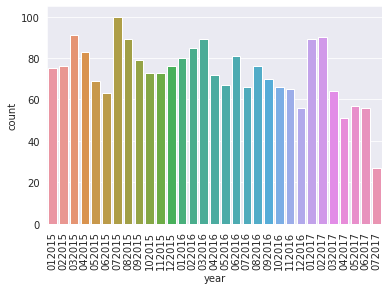

In [105]:
sns.countplot(data=df_fatalities, x='year')
plt.xticks(rotation = 90)

The rate of police fatalities has has been over 60 consistently in 2015,16 but there is a drop after April 2017. Maybe some high profile event had led to reduced usage.

# Epilogue

Now that you have analysed the data yourself, read [The Washington Post's analysis here](https://www.washingtonpost.com/graphics/investigations/police-shootings-database/).

My Conclusions: 

- The country seems to have an active gun culture. The citizens have easy access based on the number of victims armed with guns.
- There is a disproportionate amount of black and hispanic killings. 
- High school graduation is high and inversely related to poverty of states.
- The rate of police fatalities has has been over 60 consistently in 2015,16 but there is a drop after April 2017.
- Around 1/4 of the killed ones are classified as mentally-ill. Looks suspicious and probably needs to be investigated.
- Irrespective of gender, people killed were mostly from 26 to 42 years of age.